In [1]:
import numpy as np
import nengo
from nengo.solvers import LstsqL2, NoSolver
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
import nengolib
from nengolib.signal import s

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

from nengo_bioneurons import BahlNeuron

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


In [2]:
def make_stimulus(signal, freq, amp, seed):       
    if signal == 'cos':
        return nengo.Node(output=lambda t: np.cos(freq*t))
    elif signal == 'sin':
        return nengo.Node(output=lambda t: np.sin(freq*t))
    elif signal == 'white_noise':
        return nengo.Node(nengo.processes.WhiteSignal(
            period=100,
            high=freq,
            rms=amp,
            seed=seed))

# Feedforward network from "pre" (LIF) to "bio"

In [3]:
def pre_bio(
    d_bio_out,
    t=1,
    n_neurons=10,
    n_syns=1,
    signal='sin',
    freq=1,
    amp=1,
    sec='tuft',
    taus={'network': 0.05,
          'readout': 0.05},
    regs={'pre-bio': 0.1,
          'bio-out': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4},
    encoders=Uniform(-1e0,1e0),
    gain=Uniform(-1e2, 1e2),
    bias=Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'),
    verbose=True):
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=encoders,
        gain=gain,
        bias=bias,
        neuron_type=neuron_type,
        seed=seeds['es'])
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syns,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
        
    with nengo.Network(seed=seeds['ns']) as model:
        u = make_stimulus(signal, freq, amp, seeds['ss'])
        pre = nengo.Ensemble(**pre_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)

        nengo.Connection(u, pre, synapse=None, seed=seeds['cs'])
        nengo.Connection(pre, bio, solver=LstsqL2(reg=regs['pre-bio']), **conn_kwargs)
        
        p_target = nengo.Probe(u, synapse=None)
        p_act_bio = nengo.Probe(bio.neurons, synapse=None)
        p_bio = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_bio_out))

    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)

    target = nengo.Lowpass(taus['readout']).filt(sim.data[p_target])
    spikes_bio = sim.data[p_act_bio]
    act_bio = nengo.Lowpass(taus['readout']).filt(spikes_bio)
    xhat_bio = sim.data[p_bio]
    nrmse_bio = nengolib.signal.nrmse(xhat_bio, target=target)

    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
        rasterplot(sim.trange(), spikes_bio, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_bio), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
        plt.tight_layout()

        fig, (ax3) = plt.subplots(1, 1, figsize=(8, 6))
        ax3.plot(sim.trange(), target, label='target', linestyle='--')
        ax3.plot(sim.trange(), xhat_bio, alpha=0.5, label='bio')
        ax3.set(xlim=((0, t)), ylim=((-1, 1)),
                xlabel='time', ylabel='$\mathbf{x}$', title='nrmse=%.3f'%nrmse_bio)
        ax3.legend(loc='lower left')
        plt.tight_layout()
        plt.show()

    d_bio_out_new = LstsqL2(reg=regs['bio-out'])(act_bio, target)[0]
    
    return d_bio_out_new

Building finished in 0:00:01.                                                   
Simulating finished in 0:02:49.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:02:48.                                                 


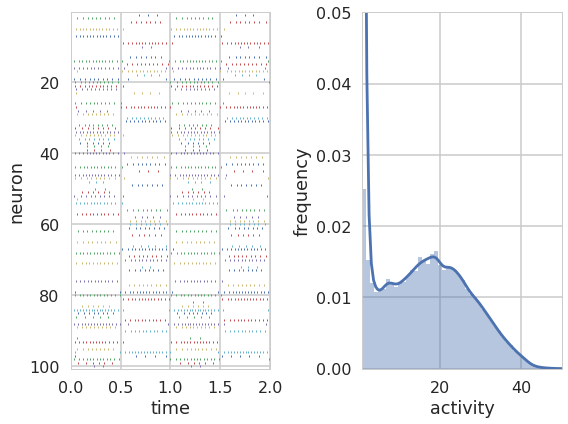

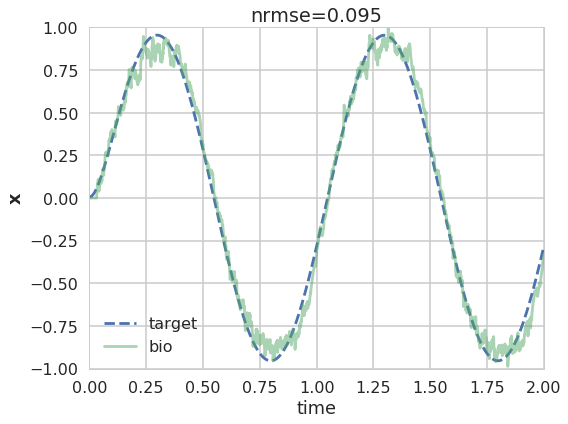

In [4]:
n_neurons = 100
t = 2
signal = 'sin'
freq = 2*np.pi

# start with readout decoders as all zeros
d_bio_out_init = np.zeros((n_neurons, 1))

# simulate the feedforward network, collect bio activities and targets,
# compute new readout decoders. Skip plotting.
d_bio_out = pre_bio(
    d_bio_out_init,
    n_neurons=n_neurons,
    t=t,
    signal=signal,
    freq=freq,
    verbose=False)

# simulate the feedforward network with the new readout decoders and plot
d_bio_out = pre_bio(
    d_bio_out,
    n_neurons=n_neurons,
    t=t,
    signal=signal,
    freq=freq,
    verbose=True)

# Feedforward network from "pre" (LIF) to "bio" to "bio2"

In [5]:
def pre_bio_bio2(
    d_bio_out,
    d_bio2_out,
    d_bio_bio2,
    t=1,
    n_neurons=10,
    n_syns=1,
    signal='sin',
    freq=1,
    amp=1,
    sec='tuft',
    taus={'network': 0.05,
          'readout': 0.05},
    regs={'pre-bio': 0.1,
          'bio-bio2': 0.1,
          'bio-out': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4},
    encoders=Uniform(-1e0,1e0),
    gain=Uniform(-1e2, 1e2),
    bias=Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'),
    verbose=True):
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=encoders,
        gain=gain,
        bias=bias,
        neuron_type=neuron_type,
        seed=seeds['es'])
    
    bio2_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=encoders,
        gain=gain,
        bias=bias,
        neuron_type=neuron_type,
        seed=1+seeds['es'])
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syns,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
    
    conn2_kwargs = dict(
        sec=sec,
        n_syn=n_syns,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
        
    with nengo.Network(seed=seeds['ns']) as model:
        u = make_stimulus(signal, freq, amp, seeds['ss'])
        pre = nengo.Ensemble(**pre_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)
        bio2 = nengo.Ensemble(**bio2_kwargs)

        nengo.Connection(u, pre, synapse=None, seed=seeds['cs'])
        nengo.Connection(pre, bio, solver=LstsqL2(reg=regs['pre-bio']), **conn_kwargs)
        nengo.Connection(bio, bio2, solver=NoSolver(d_bio_bio2), **conn2_kwargs)
        
        p_target = nengo.Probe(u, synapse=None)
        p_act_bio = nengo.Probe(bio.neurons, synapse=None)
        p_act_bio2 = nengo.Probe(bio2.neurons, synapse=None)
        p_bio = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_bio_out))
        p_bio2 = nengo.Probe(bio2, synapse=taus['readout'], solver=NoSolver(d_bio2_out))

    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)

    lpf = nengo.Lowpass(taus['readout'])
    lpf2 = nengo.Lowpass(taus['network'])
    target = lpf.filt(sim.data[p_target])
    target2 = lpf.filt(lpf2.filt(sim.data[p_target]))  # extra filter for bio_bio2 synapse

    spikes_bio = sim.data[p_act_bio]
    spikes_bio2 = sim.data[p_act_bio2]
    act_bio = lpf.filt(spikes_bio)
    act_bio2 = lpf.filt(spikes_bio2)
    xhat_bio = sim.data[p_bio]
    xhat_bio2 = sim.data[p_bio2]
    nrmse_bio = nengolib.signal.nrmse(xhat_bio, target=target)
    nrmse_bio2 = nengolib.signal.nrmse(xhat_bio2, target=target2)

    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
        rasterplot(sim.trange(), spikes_bio, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_bio), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)),
            xlabel='activity', ylabel='frequency')
        plt.tight_layout()
        
        fig, (ax3) = plt.subplots(1, 1, figsize=(8, 6))
        ax3.plot(sim.trange(), target, label='target', linestyle='--')
        ax3.plot(sim.trange(), xhat_bio, alpha=0.5, label='bio')
        ax3.set(xlim=((0, t)), ylim=((-1, 1)),
            xlabel='time', ylabel='$\mathbf{x}$', title='nrmse=%.3f'%nrmse_bio)
        ax3.legend()
        plt.tight_layout()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
        rasterplot(sim.trange(), spikes_bio2, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_bio2), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
        plt.tight_layout()

        fig, (ax3) = plt.subplots(1, 1, figsize=(8, 6))
        ax3.plot(sim.trange(), target2, label='target', linestyle='--')
        ax3.plot(sim.trange(), xhat_bio2, alpha=0.5, label='bio2')
        ax3.set(xlim=((0, t)), ylim=((-1, 1)),
            xlabel='time', ylabel='$\mathbf{x}$', title='nrmse=%.3f'%nrmse_bio2)
        ax3.legend()
        plt.tight_layout()
        plt.show()

    d_bio_out_new = LstsqL2(reg=regs['bio-out'])(act_bio, target)[0]
    d_bio2_out_new = LstsqL2(reg=regs['bio-out'])(act_bio2, target2)[0]
    d_bio_bio2_new = LstsqL2(reg=regs['bio-bio2'])(act_bio, target)[0]
    
    return d_bio_out_new, d_bio2_out_new, d_bio_bio2_new

Building finished in 0:00:01.                                                   
Simulating finished in 0:06:58.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:07:07.                                                 


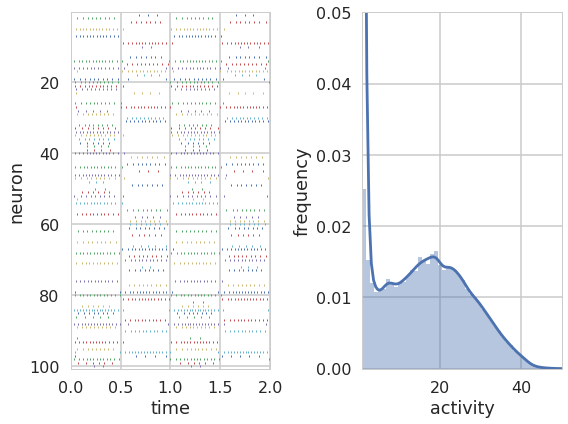

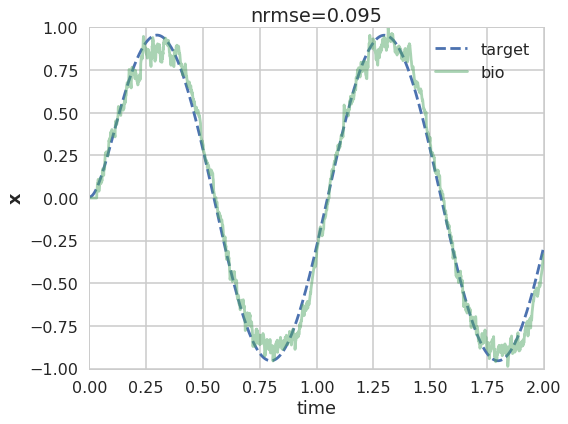

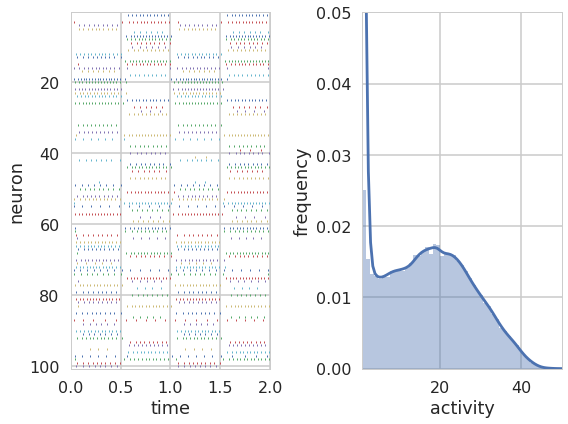

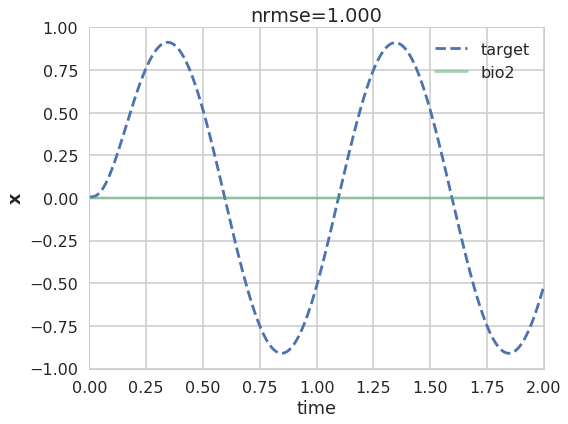

Building finished in 0:00:01.                                                   
Simulating finished in 0:07:37.                                                 


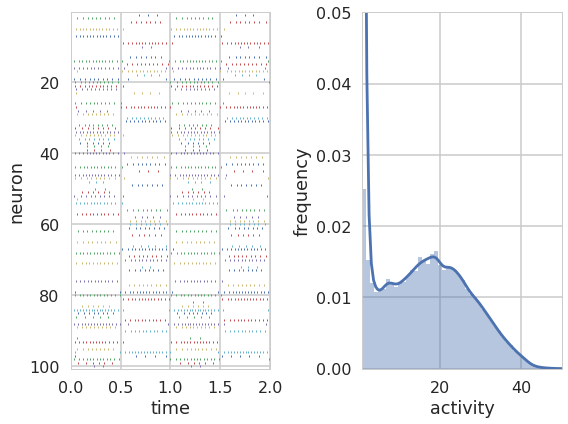

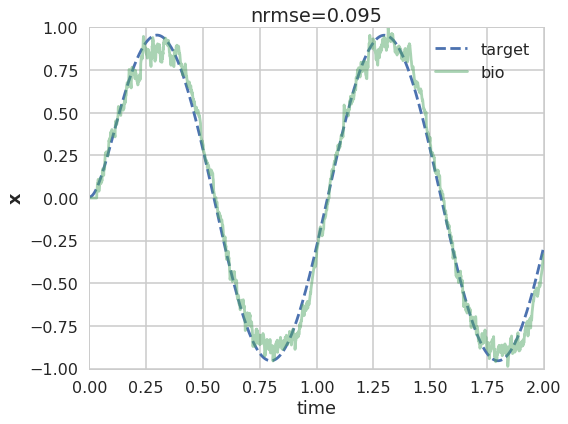

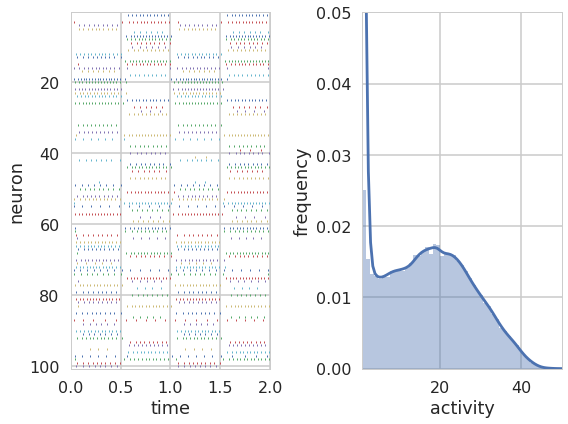

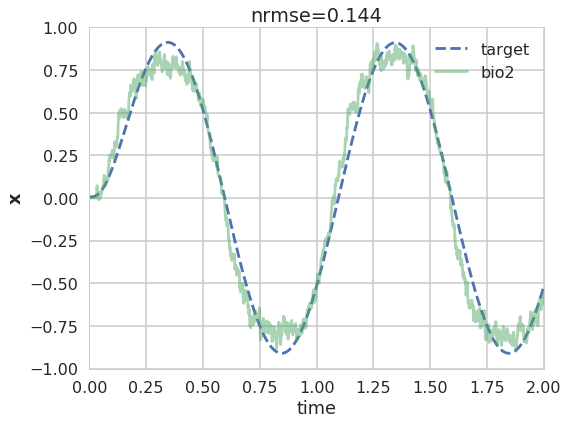

In [6]:
n_neurons = 100
t = 2
signal = 'sin'
freq = 2*np.pi

# start with readout decoders and feedforward decoders as all zeros
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio2_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

# simulate the network, collect bio activities and targets,
# compute readout decoders for bio and feedforward decoders for bio_bio2.
# Skip plotting.
d_bio_out, _, d_bio_bio = pre_bio_bio2(
    d_bio_out_init,
    d_bio2_out_init,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    signal=signal,
    freq=freq,
    verbose=False)

# simulate the network, collect bio2 activities and targets,
# compute readout decoders for bio2. Plot estimates from bio
_, d_bio2_out, _ = pre_bio_bio2(
    d_bio_out,
    d_bio2_out_init,
    d_bio_bio,
    n_neurons=n_neurons,
    t=t,
    signal=signal,
    freq=freq,
    verbose=True)

# simulate the network and plot estimates from bio and bio2
_, _, _ = pre_bio_bio2(
    d_bio_out,
    d_bio2_out,
    d_bio_bio,
    n_neurons=n_neurons,
    t=t,
    signal=signal,
    freq=freq,
    verbose=True)

# Feedforward network from "pre" (LIF) to "bio" computing the function $f(x)=x^2$

In [8]:
def pre_fx_bio(
    d_bio_out,
    t=1,
    n_neurons=10,
    n_syns=1,
    signal='sin',
    freq=1,
    amp=1,
    sec='tuft',
    taus={'network': 0.05,
          'readout': 0.05},
    regs={'pre-bio': 0.1,
          'bio-out': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4},
    encoders=Uniform(-1e0,1e0),
    gain=Uniform(-1e2, 1e2),
    bias=Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'),
    verbose=True):
    
    def fx(x):
        return x[0]**2
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=encoders,
        gain=gain,
        bias=bias,
        neuron_type=neuron_type,
        seed=seeds['es'])
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syns,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
        
    with nengo.Network(seed=seeds['ns']) as model:
        u = make_stimulus(signal, freq, amp, seeds['ss'])
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        pre = nengo.Ensemble(**pre_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)

        nengo.Connection(u, pre, synapse=None, function=fx, seed=seeds['cs'])
        nengo.Connection(pre, bio, solver=LstsqL2(reg=regs['pre-bio']), **conn_kwargs)
        nengo.Connection(u, tar, synapse=None, function=fx)
        
        p_target = nengo.Probe(tar, synapse=None)
        p_act_bio = nengo.Probe(bio.neurons, synapse=None)
        p_bio = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_bio_out))

    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)

    target = nengo.Lowpass(taus['readout']).filt(sim.data[p_target])
    spikes_bio = sim.data[p_act_bio]
    act_bio = nengo.Lowpass(taus['readout']).filt(spikes_bio)
    xhat_bio = sim.data[p_bio]
    nrmse_bio = nengolib.signal.nrmse(xhat_bio, target=target)

    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
        rasterplot(sim.trange(), spikes_bio, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_bio), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)),
            xlabel='activity', ylabel='frequency')
        plt.tight_layout()

        fig, (ax3) = plt.subplots(1, 1, figsize=(8, 6))
        ax3.plot(sim.trange(), target, label='target', linestyle='--')
        ax3.plot(sim.trange(), xhat_bio, alpha=0.5, label='bio')
        ax3.set(xlim=((0, t)), ylim=((-1, 1)),
            xlabel='time', ylabel='$\mathbf{x}$', title='nrmse=%.3f'%nrmse_bio)
        ax3.legend(loc='lower left')
        plt.tight_layout()
        plt.show()

    d_bio_out_new = LstsqL2(reg=regs['bio-out'])(act_bio, target)[0]
    
    return d_bio_out_new

Building finished in 0:00:01.                                                   
Simulating finished in 0:02:58.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:02:52.                                                 


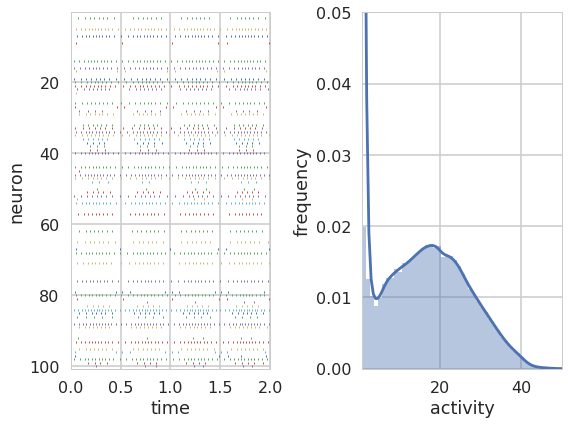

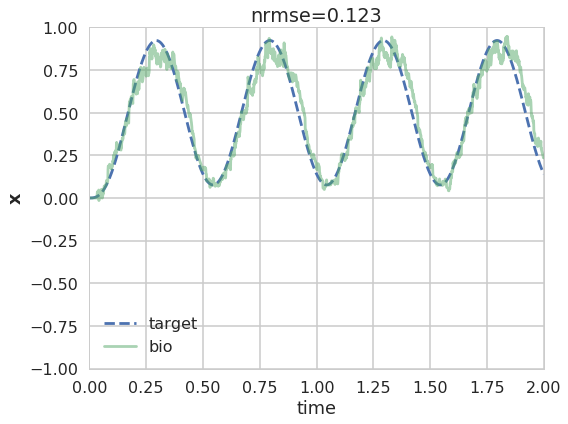

In [9]:
n_neurons = 100
t = 2
signal = 'sin'
freq = 2*np.pi

# start with readout decoders as all zeros
d_bio_out_init = np.zeros((n_neurons, 1))

# simulate the feedforward network, collect bio activities and targets,
# compute new readout decoders. Skip plotting.
d_bio_out = pre_fx_bio(
    d_bio_out_init,
    n_neurons=n_neurons,
    t=t,
    signal=signal,
    freq=freq,
    verbose=False)

# simulate the feedforward network with the new readout decoders and plot
d_bio_out = pre_fx_bio(
    d_bio_out,
    n_neurons=n_neurons,
    t=t,
    signal=signal,
    freq=freq,
    verbose=True)